# Florence-2-large on Autonomous Driving Dataset

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
%matplotlib inline  

/home/dhruv/miniconda3/envs/gaussian_splatting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

## define the prediction function

In [3]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image 

In [5]:
from pandaset import DataSet
dataset = DataSet('/home/dhruv/convolve/Data/pandaset')

seq001 = dataset['001']
seq001.load_camera()

In [61]:
image = seq001.camera['front_camera'][0]

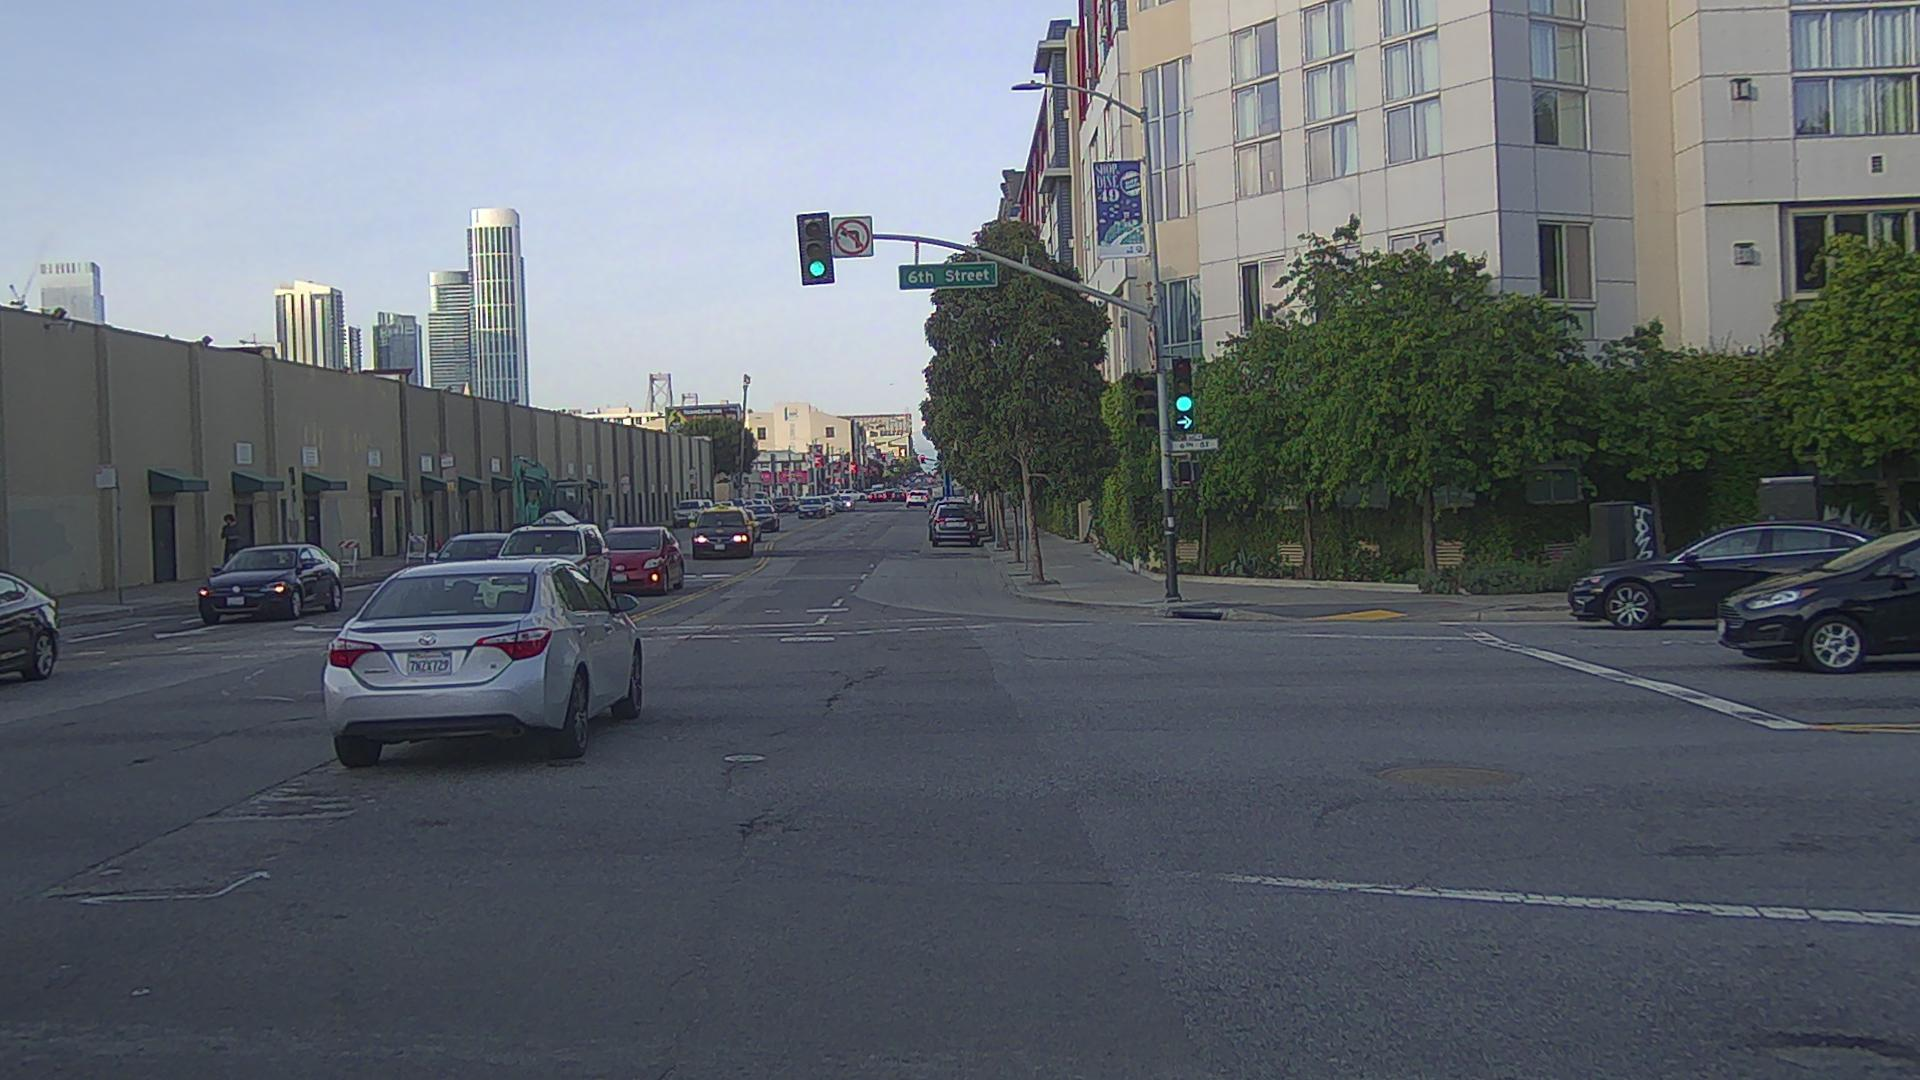

In [65]:
image

In [37]:
len(seq001.camera['front_camera'][:])

80

## Run pre-defined tasks without additional inputs 

### Object detection

OD results format: 
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...], 
    'labels': ['label1', 'label2', ...]
    } 
}

In [62]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[991.6799926757812, 0.5400000214576721, 1917.1199951171875, 536.2200317382812], [0.9599999785423279, 205.74000549316406, 720.9599609375, 604.260009765625], [0.9599999785423279, 484.3800048828125, 995.5199584960938, 766.260009765625], [308.1600036621094, 556.7400512695312, 651.8399658203125, 765.1800537109375], [1563.8399658203125, 520.02001953125, 1882.5599365234375, 629.1000366210938], [1713.5999755859375, 524.3400268554688, 1917.1199951171875, 673.3800048828125], [194.87998962402344, 542.7000122070312, 348.47998046875, 622.6199951171875], [0.9599999785423279, 570.780029296875, 66.23999786376953, 680.9400024414062], [496.3199768066406, 522.1799926757812, 613.4400024414062, 585.9000244140625], [598.0800170898438, 524.3400268554688, 688.3200073242188, 593.4600219726562], [684.47998046875, 507.0600280761719, 763.2000122070312, 557.8200073242188], [924.47998046875, 498.4200134277344, 989.7599487304688, 547.02001953125], [427.1999816894531, 530.8200073242188, 511.67999

In [63]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data, save_path=None):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):
        if label != 'car':
            continue
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  

    if save_path is None:
        # Show the plot  
        plt.show()  
    else:
        plt.savefig(save_path)
        plt.close(fig)

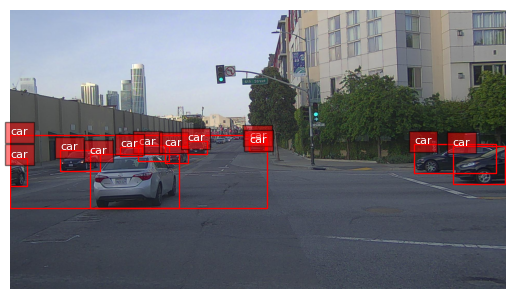

In [64]:
plot_bbox(image, results['<OD>'])

### Run on all images and save

In [ ]:
num_images = len(seq001.camera['front_camera'][:])

for i in range(num_images):
    image = seq001.camera['front_camera'][i]
    task_prompt = '<OD>'
    results = run_example(task_prompt)
    save_path = f'./outputs/{i:02}.png'
    plot_bbox(image, results['<OD>'], save_path)

In [ ]:
!ffmpeg -framerate 5 -i ./outputs/%02d.png -c:v libx264 -r 5 -pix_fmt yuv420p ./outputs/output.mp4

In [60]:
from IPython.display import Video

video_path = './outputs/output.mp4'
Video(video_path)

In [46]:
len(results['<OD>']['bboxes'])

22

### Trying Segmentation

In [48]:
image = seq001.camera['front_camera'][i]
boxes = results['<OD>']['bboxes']

In [54]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results_seg = run_example(task_prompt, text_input="cars")
print(results)

{'<OD>': {'bboxes': [[0.9599999785423279, 129.05999755859375, 997.4400024414062, 514.6199951171875], [0.9599999785423279, 431.46002197265625, 1095.3599853515625, 771.6600341796875], [0.9599999785423279, 502.7400207519531, 248.63999938964844, 770.5800170898438], [279.3599853515625, 449.82000732421875, 555.8399658203125, 620.4600219726562], [532.7999877929688, 498.4200134277344, 792.0, 672.300048828125], [216.0, 469.260009765625, 361.91998291015625, 578.3400268554688], [661.4400024414062, 433.6200256347656, 897.5999755859375, 483.3000183105469], [997.4400024414062, 448.7400207519531, 1097.280029296875, 534.0599975585938], [594.239990234375, 455.22003173828125, 701.760009765625, 504.9000244140625], [1005.1199951171875, 483.3000183105469, 1093.43994140625, 534.0599975585938], [1003.199951171875, 458.46002197265625, 1081.919921875, 490.8600158691406], [763.2000122070312, 446.58001708984375, 822.719970703125, 482.22003173828125], [813.1199951171875, 442.260009765625, 861.1199951171875, 471.4

In [55]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

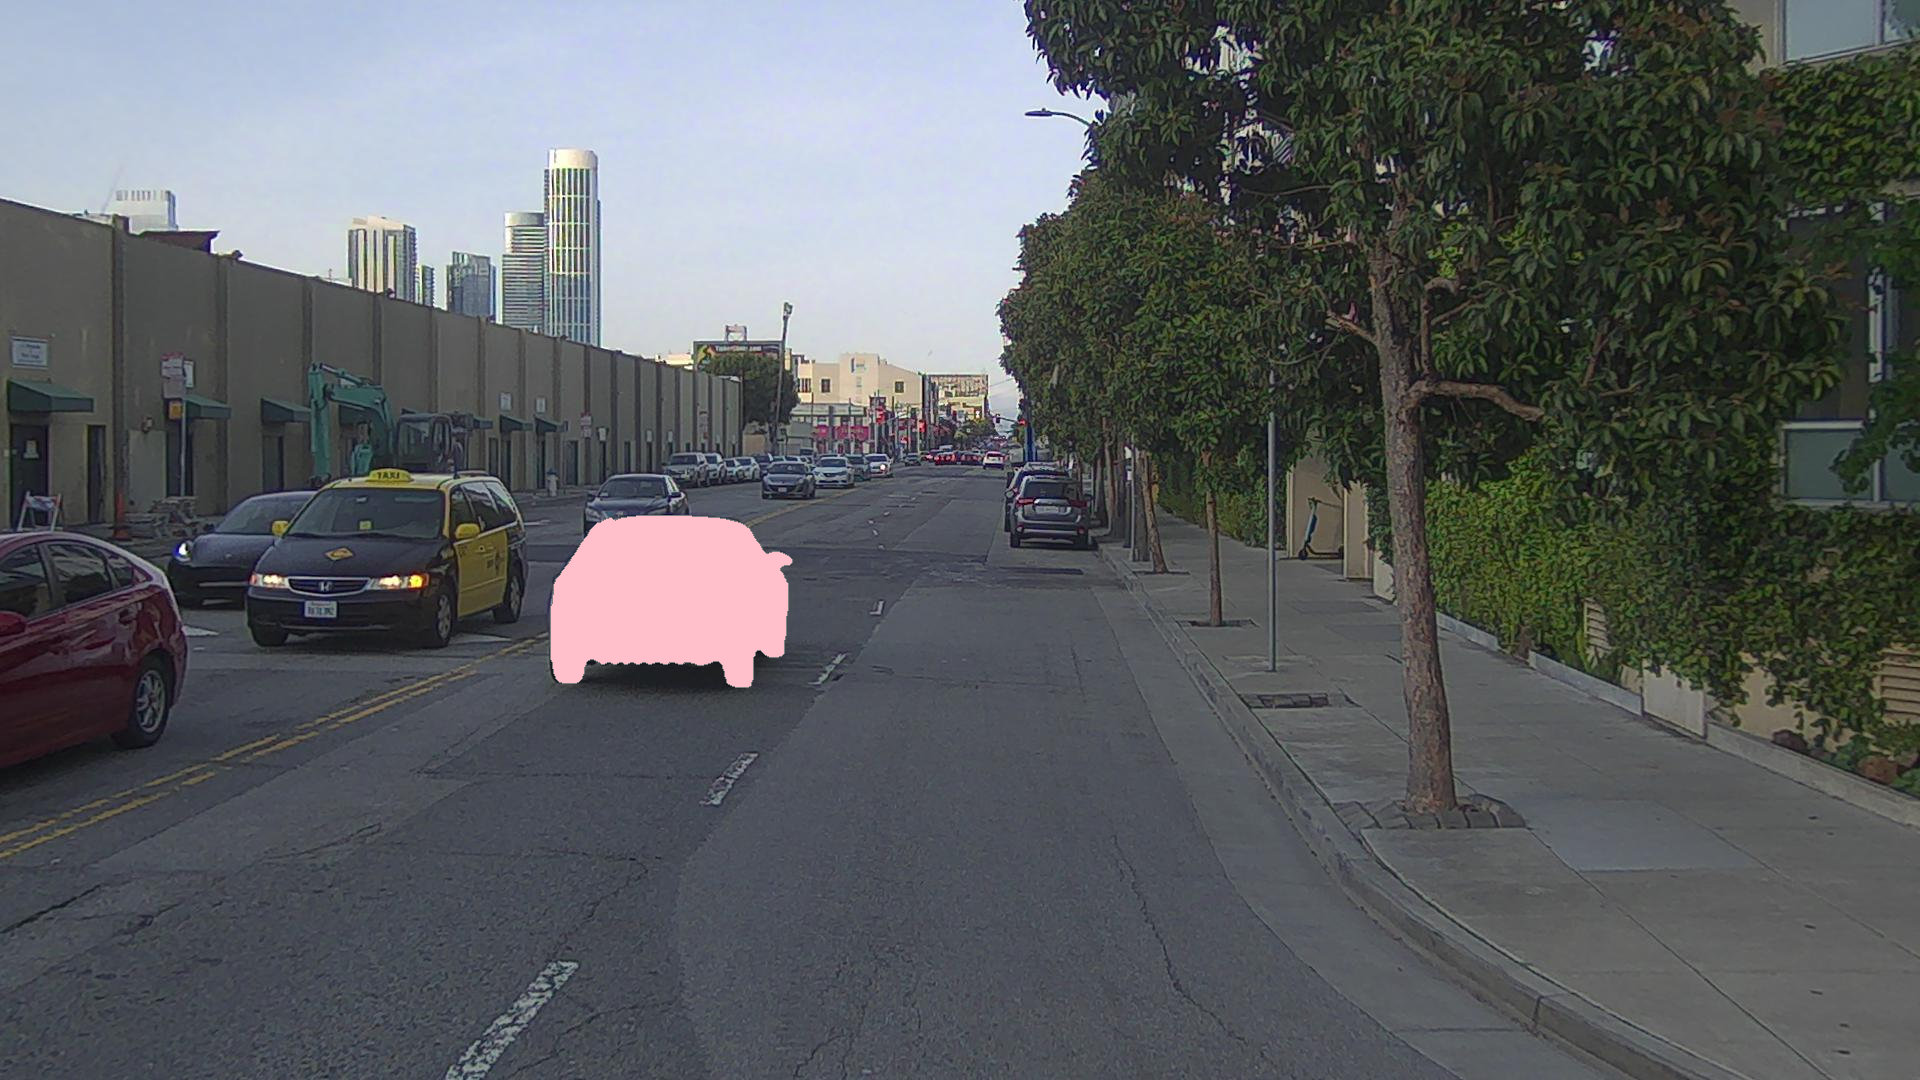

In [57]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results_seg['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)  